In [1]:
import pymc as pm
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from pymc import Model, Normal, sample, HalfNormal
import arviz as az

import yfinance as yf
from pypfopt import EfficientFrontier, objective_functions
from pypfopt import black_litterman, risk_models
from pypfopt import BlackLittermanModel, plotting
from pypfopt import DiscreteAllocation
import warnings
warnings.simplefilter(action='ignore', category=pd.errors.PerformanceWarning)

In [2]:
start = '2014-12-31'
end = '2022-12-31'
ext_factors = pd.read_parquet('factors.parquet')
stock_prices = pd.read_parquet('stock_data.parquet')
stock_prices = stock_prices.loc[start:end, :]

stock_rets = stock_prices.pct_change()
ext_factors = ext_factors.resample('M').agg(lambda x: (x + 1).prod() - 1)
stock_rets = stock_rets.resample('M').agg(lambda x: (x + 1).prod() - 1)

ext_factors[[f'{factor}_lag' for factor in ext_factors.columns]] = ext_factors.shift(1)
stock_rets[[f'{symbol}_lag' for symbol in stock_rets.columns]] = stock_rets.shift(1)

ext_factors = ext_factors.dropna()
stock_rets = stock_rets.dropna()





In [58]:
stock_rets

,AAV.BK,ADVANC.BK,AEONTS.BK,AH.BK,AMATA.BK,AOT.BK,AP.BK,ASIAN.BK,BAFS.BK,BANPU.BK,...,TTA.BK_lag,TTB.BK_lag,TTCL.BK_lag,TTW.BK_lag,TU.BK_lag,TVO.BK_lag,TWPC.BK_lag,UAC.BK_lag,VGI.BK_lag,WHA.BK_lag
Date,,,,,,,,,,,,,,,,,,,,,
2015-02-28,-0.018349,-0.048979,-0.013636,0.083916,0.120482,-4.629651e-02,0.085937,0.435714,3.906216e-02,0.244856,...,1.775146e-02,0.099291,0.170213,0.098215,-9.091157e-03,0.051887,1.546609e-01,0.241610,0.089891,0.193548
2015-03-31,-0.065421,0.042742,-0.041474,-0.070876,-0.129032,-9.385098e-02,0.035971,-0.184080,-4.511255e-02,-0.024794,...,-5.014742e-02,-0.025806,-0.081818,0.008130,-1.834832e-02,0.026906,-1.834875e-02,0.091892,-0.064000,0.075818
2015-04-30,-0.040000,0.012658,-0.010996,0.027972,0.136329,3.571425e-02,0.020833,-0.012195,1.211580e-01,0.006338,...,-1.739130e-01,-0.013245,0.049505,-0.053942,-4.926542e-02,-0.020242,-5.607470e-02,-0.153465,-0.066730,-0.125000
2015-05-31,-0.020833,-0.025000,-0.061881,-0.047619,-0.067039,3.296036e-02,-0.011939,0.006172,-1.785700e-02,-0.086207,...,9.416180e-03,-0.108412,0.217486,-0.008772,1.492539e-02,0.013889,4.950505e-02,0.079935,-0.166972,0.333333
2015-06-30,-0.063830,0.025641,-0.005277,0.000000,-0.101797,1.677855e-02,0.028571,0.042945,-6.363642e-02,-0.037736,...,-5.970162e-02,-0.023077,0.054688,-0.017699,-3.330669e-16,0.009132,-2.152649e-02,-0.121951,-0.004405,-0.090476
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-08-31,0.059701,-0.028009,-0.003012,0.226318,0.172781,3.558720e-02,0.025641,0.129204,3.636364e-02,0.082090,...,2.220446e-16,-0.024390,-0.040000,-0.018868,-4.678369e-02,-0.031746,-1.181103e-01,-0.100990,-0.120426,-0.019608
2022-09-30,0.014085,0.015625,-0.006042,0.158416,-0.110048,-3.436385e-03,-0.050000,0.033708,1.228070e-01,-0.124163,...,-5.681817e-02,0.058333,-0.050000,0.009615,9.815958e-02,0.107497,8.928599e-03,0.066079,0.004587,0.166667
2022-10-31,0.111111,-0.020513,0.010018,0.034188,0.048387,2.068962e-02,0.031579,-0.054348,-3.125000e-02,0.016260,...,-7.831321e-02,-0.031877,0.004386,-0.029137,6.857149e-02,-0.040984,-4.424774e-02,0.198347,-0.086758,0.005714


In [56]:
# train/test split
start_train_at = '2014-12-31'
end_train_at = '2021-12-31'
start_test_at = '2022-01-31'
X_train = pd.concat([stock_rets.loc[start_train_at:end_train_at, :], ext_factors.loc[start_train_at:end_train_at, :]], axis=1)
X_test = pd.concat([stock_rets.loc[start_test_at:, :], ext_factors.loc[start_test_at:, :]], axis=1)

In [57]:
X_train

,AAV.BK,ADVANC.BK,AEONTS.BK,AH.BK,AMATA.BK,AOT.BK,AP.BK,ASIAN.BK,BAFS.BK,BANPU.BK,...,VGI.BK_lag,WHA.BK_lag,mkt,E,S,G,mkt_lag,E_lag,S_lag,G_lag
2015-02-28,-0.018349,-0.048979,-0.013636,0.083916,0.120482,-0.046297,0.085937,0.435714,0.039062,0.244856,...,0.089891,0.193548,0.007893,0.446534,-0.090822,0.041178,0.055107,-0.222474,-0.315859,-0.231132
2015-03-31,-0.065421,0.042742,-0.041474,-0.070876,-0.129032,-0.093851,0.035971,-0.184080,-0.045113,-0.024794,...,-0.064000,0.075818,-0.048033,1.147584,0.931208,0.646361,0.007893,0.446534,-0.090822,0.041178
2015-04-30,-0.040000,0.012658,-0.010996,0.027972,0.136329,0.035714,0.020833,-0.012195,0.121158,0.006338,...,-0.066730,-0.125000,0.021332,0.385266,0.293041,0.445276,-0.048033,1.147584,0.931208,0.646361
2015-05-31,-0.020833,-0.025000,-0.061881,-0.047619,-0.067039,0.032960,-0.011939,0.006172,-0.017857,-0.086207,...,-0.166972,0.333333,-0.020494,-0.336553,-0.094921,-0.263620,0.021332,0.385266,0.293041,0.445276
2015-06-30,-0.063830,0.025641,-0.005277,0.000000,-0.101797,0.016779,0.028571,0.042945,-0.063636,-0.037736,...,-0.004405,-0.090476,0.003738,0.262981,0.485950,0.486148,-0.020494,-0.336553,-0.094921,-0.263620
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-08-31,0.168067,0.067312,0.164706,0.089018,0.038612,0.128319,0.063291,-0.089942,0.098790,-0.018425,...,-0.076057,-0.043750,0.082452,2.780348,4.505651,-0.685415,-0.040938,-0.931164,-0.948185,-0.240747
2021-09-30,-0.028777,0.042553,-0.080808,-0.071429,-0.037234,-0.043137,-0.029762,-0.005747,0.064220,0.145455,...,0.135135,0.065359,-0.016590,1.183720,2.100983,-0.731005,0.082452,2.780348,4.505651,-0.685415
2021-10-31,0.081482,-0.035714,0.040956,0.019231,0.127072,0.057377,0.085890,-0.086705,-0.017241,-0.080645,...,-0.031746,-0.042945,0.010872,-0.670605,0.458597,-0.689751,-0.016590,1.183720,2.100983,-0.731005
2021-11-30,-0.164384,0.089947,-0.029412,0.122642,-0.049020,-0.073643,-0.016949,0.031646,-0.122807,-0.096491,...,0.090164,0.083334,-0.034053,-0.902335,-0.978697,0.717836,0.010872,-0.670605,0.458597,-0.689751


In [54]:
X_test


,AAV.BK,ADVANC.BK,AEONTS.BK,AH.BK,AMATA.BK,AOT.BK,AP.BK,ASIAN.BK,BAFS.BK,BANPU.BK,...,VGI.BK_lag,WHA.BK_lag,mkt,E,S,G,mkt_lag,E_lag,S_lag,G_lag
2022-01-31,-0.015748,-0.043478,-0.029178,-0.037037,1.904772e-02,4.508193e-02,0.068063,-0.078212,6.862745e-02,0.047170,...,-0.014925,0.073171,-0.004626,2.728603,3.487196,1.490064,0.056876,-0.890117,-0.522251,-0.613177
2022-02-28,0.008000,0.059629,0.076503,-0.119231,-4.440892e-16,7.843163e-03,0.039216,-0.060606,-5.504587e-02,-0.018018,...,-0.166667,-0.028409,0.025024,-0.625301,-0.924748,-0.453828,-0.004626,2.728603,3.487196,1.490064
2022-03-31,0.023810,0.017467,-0.007614,0.104693,3.271033e-02,3.112839e-02,0.037736,0.000000,2.220446e-16,0.009174,...,0.102627,-0.005848,0.012803,-0.757457,-0.507373,-0.758812,0.025024,-0.625301,-0.924748,-0.453828
2022-04-30,0.100775,-0.077253,-0.015345,-0.056452,-1.235725e-04,7.547195e-03,0.072727,0.097089,1.262136e-01,0.143480,...,-0.120690,-0.005882,-0.011661,0.471555,-0.627084,0.801230,0.012803,-0.757457,-0.507373,-0.758812
2022-05-31,-0.007042,0.009302,0.006667,0.025641,-7.798159e-02,4.494385e-02,-0.005215,-0.012048,-1.724138e-02,0.008130,...,-0.027451,-0.005917,0.001255,-0.056896,-0.411707,0.781736,-0.011661,0.471555,-0.627084,0.801230
2022-06-30,0.021277,-0.103687,-0.096859,-0.087500,-8.955231e-02,1.792104e-02,-0.107143,0.054878,8.771930e-03,0.016129,...,0.078629,-0.025651,-0.057464,0.134897,1.574954,0.405824,0.001255,-0.056896,-0.411707,0.781736
2022-07-31,-0.069444,0.033419,-0.037681,-0.036530,-1.639337e-02,-1.056336e-02,-0.025000,-0.075144,-4.347826e-02,0.063492,...,-0.069159,-0.043750,0.006373,1.466634,1.668548,-0.675061,-0.057464,0.134897,1.574954,0.405824
2022-08-31,0.059701,-0.028009,-0.003012,0.226318,1.727806e-01,3.558720e-02,0.025641,0.129204,3.636364e-02,0.082090,...,-0.120426,-0.019608,0.046397,0.524031,-0.439201,-0.596649,0.006373,1.466634,1.668548,-0.675061
2022-09-30,0.014085,0.015625,-0.006042,0.158416,-1.100479e-01,-3.436385e-03,-0.050000,0.033708,1.228070e-01,-0.124163,...,0.004587,0.166667,-0.025462,2.264945,-0.532802,0.491849,0.046397,0.524031,-0.439201,-0.596649
2022-10-31,0.111111,-0.020513,0.010018,0.034188,4.838709e-02,2.068962e-02,0.031579,-0.054348,-3.125000e-02,0.016260,...,-0.086758,0.005714,0.013131,0.784105,-0.470394,-0.798323,-0.025462,2.264945,-0.532802,0.491849


In [39]:
model_dict = {}
symbols = ['MINT.BK', 'BANPU.BK', 'TOP.BK', 
           'DELTA.BK', 'IRPC.BK', 'PTTGC.BK', 
           'WHA.BK', 'SCC.BK','CPN.BK', 
           'CENTEL.BK', 'PTT.BK', 'BCP.BK']
# symbols = ['MINT.BK']
for symbol in symbols:
    with Model() as model:
        beta0 = Normal('beta0', 0, 10)
        beta1 = Normal('beta1', 0, 10)
        beta2 = Normal('beta2', 0, 10)
        beta3 = Normal('beta3', 0, 10)
        beta4 = Normal('beta4', 0, 10)
        stdev = HalfNormal('stdev', 10)
        X_l1 = pm.MutableData( 'lagged_X', X_train.loc[:, f'{symbol}_lag'].values)
        R_l1 = pm.MutableData('lagged_R_l1', X_train.loc[:, 'mkt_lag'].values)
        R_l2 = pm.MutableData('lagged_R_l2',X_train.loc[:, 'E_lag'].values)
        R_l3 = pm.MutableData('lagged_R_l3',X_train.loc[:, 'S_lag'].values)
        R_l4 = pm.MutableData('lagged_R_l4',X_train.loc[:, 'G_lag'].values)
        X = X_train.loc[:, symbol].values
        mu = X_l1 * beta0 + R_l1 * beta1 + R_l2 * beta2 + R_l3 * beta3 + R_l4 * beta4
        obs = Normal('obs', mu=mu, sigma=stdev, observed=X)
        ar_trace = sample(20000, chains=1)
        model_dict[symbol] = ar_trace


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [beta0, beta1, beta2, beta3, beta4, stdev]


Sampling 1 chain for 1_000 tune and 20_000 draw iterations (1_000 + 20_000 draws total) took 28 seconds.
Only one chain was sampled, this makes it impossible to run some convergence checks
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [beta0, beta1, beta2, beta3, beta4, stdev]


Sampling 1 chain for 1_000 tune and 20_000 draw iterations (1_000 + 20_000 draws total) took 28 seconds.
Only one chain was sampled, this makes it impossible to run some convergence checks
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [beta0, beta1, beta2, beta3, beta4, stdev]


Sampling 1 chain for 1_000 tune and 20_000 draw iterations (1_000 + 20_000 draws total) took 30 seconds.
Only one chain was sampled, this makes it impossible to run some convergence checks
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [beta0, beta1, beta2, beta3, beta4, stdev]


Sampling 1 chain for 1_000 tune and 20_000 draw iterations (1_000 + 20_000 draws total) took 25 seconds.
Only one chain was sampled, this makes it impossible to run some convergence checks
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [beta0, beta1, beta2, beta3, beta4, stdev]


Sampling 1 chain for 1_000 tune and 20_000 draw iterations (1_000 + 20_000 draws total) took 29 seconds.
Only one chain was sampled, this makes it impossible to run some convergence checks
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [beta0, beta1, beta2, beta3, beta4, stdev]


Sampling 1 chain for 1_000 tune and 20_000 draw iterations (1_000 + 20_000 draws total) took 32 seconds.
Only one chain was sampled, this makes it impossible to run some convergence checks
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [beta0, beta1, beta2, beta3, beta4, stdev]


Sampling 1 chain for 1_000 tune and 20_000 draw iterations (1_000 + 20_000 draws total) took 30 seconds.
Only one chain was sampled, this makes it impossible to run some convergence checks
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [beta0, beta1, beta2, beta3, beta4, stdev]


Sampling 1 chain for 1_000 tune and 20_000 draw iterations (1_000 + 20_000 draws total) took 27 seconds.
Only one chain was sampled, this makes it impossible to run some convergence checks
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [beta0, beta1, beta2, beta3, beta4, stdev]


Sampling 1 chain for 1_000 tune and 20_000 draw iterations (1_000 + 20_000 draws total) took 33 seconds.
Only one chain was sampled, this makes it impossible to run some convergence checks
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [beta0, beta1, beta2, beta3, beta4, stdev]


Sampling 1 chain for 1_000 tune and 20_000 draw iterations (1_000 + 20_000 draws total) took 27 seconds.
Only one chain was sampled, this makes it impossible to run some convergence checks
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [beta0, beta1, beta2, beta3, beta4, stdev]


Sampling 1 chain for 1_000 tune and 20_000 draw iterations (1_000 + 20_000 draws total) took 29 seconds.
Only one chain was sampled, this makes it impossible to run some convergence checks
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [beta0, beta1, beta2, beta3, beta4, stdev]


Sampling 1 chain for 1_000 tune and 20_000 draw iterations (1_000 + 20_000 draws total) took 30 seconds.
Only one chain was sampled, this makes it impossible to run some convergence checks


In [59]:
import numpy as np
def predict(X, model):
    draw = model.posterior['draw'].shape[0]
    
    beta0_sample = model.posterior['beta0']
    beta1_sample = model.posterior['beta1']
    beta2_sample = model.posterior['beta2']
    beta3_sample = model.posterior['beta3']
    beta4_sample = model.posterior['beta4']
    next_period_return = (X.filter(like='.BK').iloc[-1, 0] * beta0_sample +
                          X['mkt_lag'].iloc[-1] * beta1_sample + 
                          X['E_lag'].iloc[-1] * beta2_sample + 
                          X['S_lag'].iloc[-1] * beta3_sample + 
                          X['G_lag'].iloc[-1] * beta4_sample)

    next_period_return = np.array(next_period_return).reshape(draw, )
    return next_period_return 

In [62]:
stock_prices

,AAV.BK,ADVANC.BK,AEONTS.BK,AH.BK,AMATA.BK,AOT.BK,AP.BK,ASIAN.BK,BAFS.BK,BANPU.BK,...,TTA.BK,TTB.BK,TTCL.BK,TTW.BK,TU.BK,TVO.BK,TWPC.BK,UAC.BK,VGI.BK,WHA.BK
Date,,,,,,,,,,,,,,,,,,,,,
2015-01-05,3.572461,166.043442,82.875908,8.761683,12.529393,24.920393,3.948691,0.886575,19.654974,9.821994,...,14.421543,1.891242,21.169041,6.563799,15.530849,11.395597,2.835512,4.785787,4.915983,1.967089
2015-01-06,3.771853,164.709763,83.259590,8.698196,12.529393,24.829111,3.915509,0.880287,19.977186,9.901848,...,14.933551,1.864416,21.259121,6.505195,14.966094,11.556857,2.823497,4.753666,4.958362,1.903635
2015-01-07,3.805086,168.710800,83.643288,8.825176,12.529393,25.833227,3.981873,0.886575,19.977186,9.981701,...,14.848216,1.904655,21.619448,6.446590,15.248470,11.449352,2.859542,4.817905,5.000742,1.951225
2015-01-08,3.838319,166.710281,84.410652,8.888667,12.996328,26.380930,4.114603,0.905438,19.977186,9.981701,...,15.361932,1.958308,21.799608,6.622406,15.601446,11.556857,2.883572,4.850025,5.000742,1.967089
2015-01-09,3.921399,165.376602,84.410652,8.888667,12.996328,26.563498,4.114603,0.899150,20.460505,10.181334,...,15.189553,1.958308,21.979771,6.622406,15.460255,11.503102,2.931631,4.850025,5.000742,1.935362
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-12-26,2.880000,180.750458,170.860962,27.210169,19.741316,73.307503,10.911418,12.637019,29.672602,12.190159,...,7.711340,1.271752,4.396313,8.102434,15.521509,26.578030,4.915534,4.272338,4.082740,3.743514
2022-12-27,3.020000,182.162567,174.733170,27.436922,20.033064,75.047005,10.911418,12.732035,31.418049,12.099861,...,7.805958,1.281103,4.396313,8.147699,15.708515,26.578030,4.963257,4.327584,4.121809,3.801403
2022-12-28,3.060000,182.633255,174.733170,26.756668,20.616550,75.047005,11.006300,12.827049,31.168699,12.370753,...,7.758649,1.290454,4.396313,8.192964,15.615012,26.811171,4.963257,4.309169,4.141344,3.955775


In [63]:
portfolio = stock_prices.loc[start_test_at:, :]
portfolio.head()

,AAV.BK,ADVANC.BK,AEONTS.BK,AH.BK,AMATA.BK,AOT.BK,AP.BK,ASIAN.BK,BAFS.BK,BANPU.BK,...,TTA.BK,TTB.BK,TTCL.BK,TTW.BK,TU.BK,TVO.BK,TWPC.BK,UAC.BK,VGI.BK,WHA.BK
Date,,,,,,,,,,,,,,,,,,,,,
2022-01-31,2.50,199.941437,171.825989,22.559704,20.326788,63.367500,9.234010,15.077836,27.179106,9.492840,...,8.561494,1.215806,4.689401,10.020440,18.602667,25.994583,5.259785,4.641768,5.113986,3.167914
2022-02-01,2.62,200.850235,171.825989,22.559704,20.706728,63.864502,9.234010,15.351979,27.179106,9.407319,...,8.654052,1.215806,4.708940,10.020440,18.424654,25.585218,5.352062,4.864930,5.206967,3.186440
2022-02-02,2.56,202.667908,177.929092,22.559704,20.706728,63.616001,9.324539,15.534741,27.179106,9.321797,...,8.700330,1.242625,4.669862,9.934796,18.246637,25.994583,5.259785,5.043460,5.206967,3.167914
2022-02-03,2.56,202.667908,179.337509,21.431719,20.611744,63.616001,9.143481,15.900265,27.179106,9.236277,...,8.931722,1.197927,4.865253,9.934796,18.691677,25.789900,5.259785,4.954195,5.346439,3.260543
2022-02-04,2.54,199.941437,178.398575,20.650806,20.611744,63.864502,9.324539,15.808883,27.428455,9.321797,...,8.792886,1.197927,5.470968,9.934796,18.691677,25.789900,5.259785,4.909563,5.532403,3.223491


In [64]:
market_prices = yf.download("^SET.BK", start=start, end=end)['Adj Close']
market_prices.head()


[*********************100%%**********************]  1 of 1 completed


Date
2023-01-03    1678.969971
2023-01-04    1673.250000
2023-01-05    1663.859985
2023-01-06    1673.859985
2023-01-09    1691.119995
Name: Adj Close, dtype: float64

In [65]:
mcaps = {}
for t in symbols:
    stock = yf.Ticker(t)
    mcaps[t] = stock.info["marketCap"]
mcaps

{'MINT.BK': 189944332288,
 'BANPU.BK': 55604895744,
 'TOP.BK': 132355031040,
 'DELTA.BK': 907468931072,
 'IRPC.BK': 38984245248,
 'PTTGC.BK': 175845163008,
 'WHA.BK': 72043577344,
 'SCC.BK': 302400012288,
 'CPN.BK': 286109990912,
 'CENTEL.BK': 60412502016,
 'PTT.BK': 971142004736,
 'BCP.BK': 61961404416}

In [66]:
S = risk_models.CovarianceShrinkage(portfolio).ledoit_wolf()

delta = black_litterman.market_implied_risk_aversion(market_prices)
delta

0.03606882566847272

In [67]:
market_prior = black_litterman.market_implied_prior_returns(mcaps, delta, S)
market_prior


ValueError: matrices are not aligned

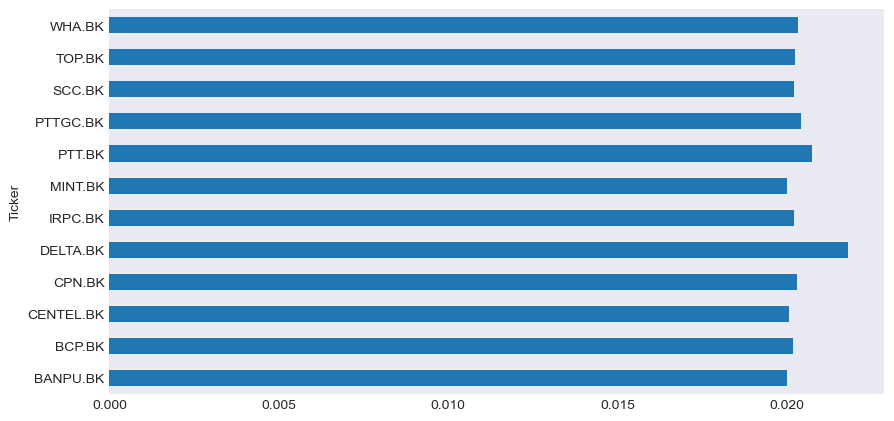

In [68]:
market_prior.plot.barh(figsize=(10,5));


In [69]:
views = {}
view_uncertainty = {}
for symbol in symbols:
    X = pd.concat([ext_factors.filter(like='lag'),stock_rets[f'{symbol}_lag']], axis=1)
    pred = predict(X, model_dict[symbol])
    views[symbol] = pred.mean()
    view_uncertainty[symbol] = pred.var()

In [70]:
views

{'MINT.BK': -0.03621354051338238,
 'BANPU.BK': 0.046095741833519825,
 'TOP.BK': -0.009513018876831857,
 'DELTA.BK': 0.07751349326114414,
 'IRPC.BK': 0.019523456294543193,
 'PTTGC.BK': -0.008309937786784847,
 'WHA.BK': -0.014283155690263153,
 'SCC.BK': 0.009788950820292278,
 'CPN.BK': -0.040166731382415756,
 'CENTEL.BK': -0.018789862078058262,
 'PTT.BK': -0.0028703703262191404,
 'BCP.BK': -0.02227460662442489}

In [71]:
view_uncertainty

{'MINT.BK': 0.0006144466560528497,
 'BANPU.BK': 0.0005202677783869074,
 'TOP.BK': 0.0006072979294122436,
 'DELTA.BK': 0.002516089887777362,
 'IRPC.BK': 0.0005231928249048433,
 'PTTGC.BK': 0.000661118694093447,
 'WHA.BK': 0.00048020171027099223,
 'SCC.BK': 0.00016136995873849942,
 'CPN.BK': 0.000278077629797357,
 'CENTEL.BK': 0.0007262008533353701,
 'PTT.BK': 0.0005766320184885944,
 'BCP.BK': 0.00044872549276746943}

In [72]:
omega = np.diag(list(view_uncertainty.values()))
omega

array([[0.00061445, 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        ],
       [0.        , 0.00052027, 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        ],
       [0.        , 0.        , 0.0006073 , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        ],
       [0.        , 0.        , 0.        , 0.00251609, 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        ],
       [0.        , 0.        , 0.        , 0.        , 0.00052319,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        ],
       [0.        , 0.        , 0.        , 0.        , 0.        ,
        0.00066112, 0.        , 0.        , 0.        , 0.        ,
        0.        ,

In [73]:
bl = BlackLittermanModel(S, pi="market", risk_aversion=delta,
                         absolute_views=views, omega=omega)

ValueError: Please pass a series/array of market caps via the market_caps keyword argument

In [74]:
ret_bl = bl.bl_returns()
ret_bl

Ticker
BANPU.BK     0.045988
BCP.BK      -0.009446
CENTEL.BK    0.013000
CPN.BK      -0.017324
DELTA.BK     0.064269
IRPC.BK      0.015264
MINT.BK     -0.013251
PTT.BK       0.012765
PTTGC.BK     0.007332
SCC.BK       0.007980
TOP.BK       0.006962
WHA.BK       0.010688
dtype: float64

In [75]:
rets_df = pd.DataFrame([market_prior, ret_bl, pd.Series(views)],
                       index=["Prior", "Posterior", "Views"]).T
rets_df

,Prior,Posterior,Views
BANPU.BK,0.020016,0.045988,0.046096
BCP.BK,0.020196,-0.009446,-0.022275
CENTEL.BK,0.020066,0.013000,-0.018790
CPN.BK,0.020297,-0.017324,-0.040167
DELTA.BK,0.021795,0.064269,0.077513
IRPC.BK,0.020216,0.015264,0.019523
MINT.BK,0.020021,-0.013251,-0.036214
PTT.BK,0.020740,0.012765,-0.002870
PTTGC.BK,0.020412,0.007332,-0.008310
SCC.BK,0.020202,0.007980,0.009789


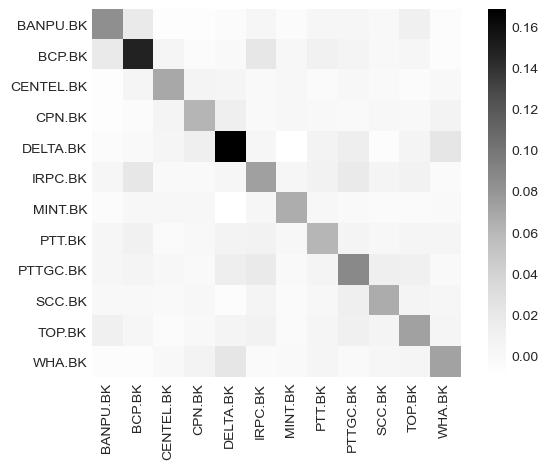

In [76]:
S_bl = bl.bl_cov()
plotting.plot_covariance(S_bl);

In [77]:
ef = EfficientFrontier(ret_bl, S_bl)
ef.add_objective(objective_functions.L2_reg)
ef.max_sharpe(risk_free_rate=0.0227/12)
weights = ef.clean_weights()
weights

C:\Users\Eakka\anaconda3\envs\pymc_env\Lib\site-packages\pypfopt\efficient_frontier\efficient_frontier.py:259: UserWarning: max_sharpe transforms the optimization problem so additional objectives may not work as expected.
  warnings.warn(


OrderedDict([('BANPU.BK', 0.27779),
             ('BCP.BK', 0.0),
             ('CENTEL.BK', 0.07128),
             ('CPN.BK', 0.0),
             ('DELTA.BK', 0.3608),
             ('IRPC.BK', 0.08172),
             ('MINT.BK', 0.0),
             ('PTT.BK', 0.06572),
             ('PTTGC.BK', 0.02666),
             ('SCC.BK', 0.03991),
             ('TOP.BK', 0.0259),
             ('WHA.BK', 0.05022)])

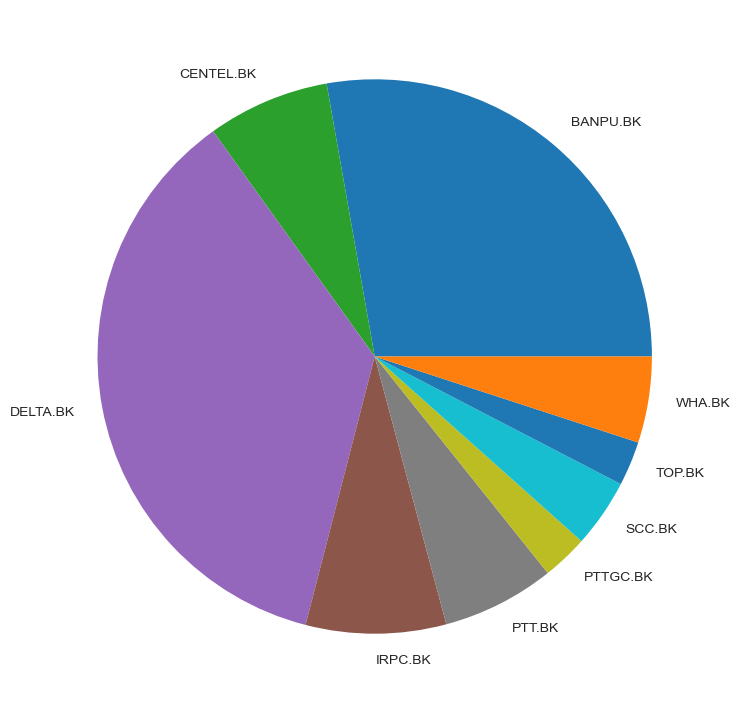

In [78]:
pd.Series(weights).plot.pie(figsize=(9,9));

In [79]:
ef.portfolio_performance(risk_free_rate=0.0227/12, verbose=True)

Expected annual return: 4.0%
Annual volatility: 17.5%
Sharpe Ratio: 0.22


(0.04020713303997835, 0.1748718130317077, 0.21910601662467089)

In [80]:
portfolio

,AAV.BK,ADVANC.BK,AEONTS.BK,AH.BK,AMATA.BK,AOT.BK,AP.BK,ASIAN.BK,BAFS.BK,BANPU.BK,...,TTA.BK,TTB.BK,TTCL.BK,TTW.BK,TU.BK,TVO.BK,TWPC.BK,UAC.BK,VGI.BK,WHA.BK
Date,,,,,,,,,,,,,,,,,,,,,
2022-01-31,2.50,199.941437,171.825989,22.559704,20.326788,63.367500,9.234010,15.077836,27.179106,9.492840,...,8.561494,1.215806,4.689401,10.020440,18.602667,25.994583,5.259785,4.641768,5.113986,3.167914
2022-02-01,2.62,200.850235,171.825989,22.559704,20.706728,63.864502,9.234010,15.351979,27.179106,9.407319,...,8.654052,1.215806,4.708940,10.020440,18.424654,25.585218,5.352062,4.864930,5.206967,3.186440
2022-02-02,2.56,202.667908,177.929092,22.559704,20.706728,63.616001,9.324539,15.534741,27.179106,9.321797,...,8.700330,1.242625,4.669862,9.934796,18.246637,25.994583,5.259785,5.043460,5.206967,3.167914
2022-02-03,2.56,202.667908,179.337509,21.431719,20.611744,63.616001,9.143481,15.900265,27.179106,9.236277,...,8.931722,1.197927,4.865253,9.934796,18.691677,25.789900,5.259785,4.954195,5.346439,3.260543
2022-02-04,2.54,199.941437,178.398575,20.650806,20.611744,63.864502,9.324539,15.808883,27.428455,9.321797,...,8.792886,1.197927,5.470968,9.934796,18.691677,25.789900,5.259785,4.909563,5.532403,3.223491
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-12-26,2.88,180.750458,170.860962,27.210169,19.741316,73.307503,10.911418,12.637019,29.672602,12.190159,...,7.711340,1.271752,4.396313,8.102434,15.521509,26.578030,4.915534,4.272338,4.082740,3.743514
2022-12-27,3.02,182.162567,174.733170,27.436922,20.033064,75.047005,10.911418,12.732035,31.418049,12.099861,...,7.805958,1.281103,4.396313,8.147699,15.708515,26.578030,4.963257,4.327584,4.121809,3.801403
2022-12-28,3.06,182.633255,174.733170,26.756668,20.616550,75.047005,11.006300,12.827049,31.168699,12.370753,...,7.758649,1.290454,4.396313,8.192964,15.615012,26.811171,4.963257,4.309169,4.141344,3.955775


In [ ]:
for month in []